In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

Using TensorFlow backend.


In [2]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [3]:
content_image=Image.open('/Users/xinyingpeng/Downloads/AI_school/study_group/Neural-Style-Transfer-master/content.png')
content_image=content_image.resize((512,512))

In [4]:
style_image= Image.open('/Users/xinyingpeng/Downloads/AI_school/study_group/Neural-Style-Transfer-master/style.png')
style_image=style_image.resize((512,512))
print(style_image)

<PIL.Image.Image image mode=RGB size=512x512 at 0x10E485DD8>


In [5]:
style_image.size
type(content_image)

PIL.Image.Image

In [6]:
#image 變成一個向量矩陣
content_array=np.asarray(content_image,dtype='float32')
print(content_array)
#每個陣列有三個元素 這個陣列有512個 這個含有512個陣列的陣列 有512個 最外面再多加一層維度 axis=0  but why?
content_array=np.expand_dims(content_array,axis=0)
print(content_array.shape)
#content_array=np.array(content_array).copy()

[[[ 236.  237.  241.]
  [ 236.  237.  241.]
  [ 234.  238.  241.]
  ..., 
  [ 233.  229.  226.]
  [ 237.  236.  232.]
  [ 231.  230.  225.]]

 [[ 236.  237.  241.]
  [ 236.  237.  241.]
  [ 234.  238.  241.]
  ..., 
  [ 219.  215.  212.]
  [ 232.  231.  227.]
  [ 235.  234.  229.]]

 [[ 236.  237.  241.]
  [ 234.  238.  241.]
  [ 234.  238.  241.]
  ..., 
  [ 211.  210.  206.]
  [ 233.  232.  228.]
  [ 232.  233.  227.]]

 ..., 
 [[ 219.  178.  156.]
  [ 220.  180.  155.]
  [ 221.  179.  155.]
  ..., 
  [ 165.  163.  122.]
  [ 168.  165.  124.]
  [ 169.  165.  127.]]

 [[ 223.  178.  157.]
  [ 225.  178.  158.]
  [ 224.  179.  158.]
  ..., 
  [ 166.  164.  125.]
  [ 168.  166.  127.]
  [ 167.  165.  126.]]

 [[ 223.  177.  154.]
  [ 225.  176.  159.]
  [ 224.  177.  159.]
  ..., 
  [ 167.  165.  127.]
  [ 170.  168.  130.]
  [ 166.  167.  127.]]]
(1, 512, 512, 3)


In [8]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
#print(content_array.shape)
#print(style_array.shape)
#第一個代表 一個陣列 每一個陣列又再包含一個陣列 在裡面有三個元素 應該是分別代表ＲＧＢ
#a=content_array[0][0][0][1:2]
#print(a)

In [10]:
#減去中心值 留下高頻的訊息
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
#reverse RGB.   but why?
content_array=content_array[:, :, :, ::-1]

In [11]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

style_array=style_array[:, :, :, ::-1]


In [12]:
height=512
width=512
#實例化一個變量 並且返回它
content_image=backend.variable(content_array)
print(content_image)
style_image=backend.variable(style_array)
print(style_image)
#建立一個要讓tensor 執行的graph
combination_image=backend.placeholder((1,height,width,3))

Tensor("Variable/read:0", shape=(1, 512, 512, 3), dtype=float32)
Tensor("Variable_1/read:0", shape=(1, 512, 512, 3), dtype=float32)


In [13]:
#連接兩個矩陣的操作
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [14]:
#透過pre train 找出最佳的初始w 
#可以將layer 的輸出 最為此處的輸入？   include_top 不包括加在最後3層的卷積層
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
print('model')

model


In [15]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0
#print(layer.name)

In [16]:
layers=dict([(layer.name, layer.output) for layer in model.layers])
print(model.layers)

[<keras.engine.topology.InputLayer object at 0x11d1fe550>, <keras.layers.convolutional.Conv2D object at 0x11d1fe320>, <keras.layers.convolutional.Conv2D object at 0x11d1fe7f0>, <keras.layers.pooling.MaxPooling2D object at 0x11f02eda0>, <keras.layers.convolutional.Conv2D object at 0x11f04c080>, <keras.layers.convolutional.Conv2D object at 0x11f04ca58>, <keras.layers.pooling.MaxPooling2D object at 0x11f058710>, <keras.layers.convolutional.Conv2D object at 0x11f0759e8>, <keras.layers.convolutional.Conv2D object at 0x11f075278>, <keras.layers.convolutional.Conv2D object at 0x11f090908>, <keras.layers.pooling.MaxPooling2D object at 0x11f0aaf28>, <keras.layers.convolutional.Conv2D object at 0x11f0c94a8>, <keras.layers.convolutional.Conv2D object at 0x11f0c9cc0>, <keras.layers.convolutional.Conv2D object at 0x11f0e5f60>, <keras.layers.pooling.MaxPooling2D object at 0x11f101940>, <keras.layers.convolutional.Conv2D object at 0x11f10fc88>, <keras.layers.convolutional.Conv2D object at 0x11f11f780

In [122]:
#給予初始值
loss=backend.variable(0.)

In [123]:
# 計算 content loss 
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [124]:
layer_features=layers['block2_conv2']

#為何會要取這一層'block2_conv2' 的 value
print(layers['block1_conv2'])
#Tensor("block2_conv2/Relu:0", shape=(3, 256, 256, 128), dtype=float32)
#為何要取第0個與第二個
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

Tensor("block1_conv2_1/Relu:0", shape=(3, 512, 512, 64), dtype=float32)


In [125]:
# 計算 風格 loss 的 gram matrix
def gram_matrix(x):
    # flattern n phase to 2 phase ...  premute按照給定的模式重排一個張量的軸 
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    #dot 求張量的乘績
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [126]:
# 計算 風格 loss
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [127]:

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [128]:
# 彙總上面三項的損失(loss)
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [129]:
# 計算 損失總差異(total variation loss)，以利合成圖的連貫性
# 將合成圖的相減 a= 留下陣列第0個hight    b= 留下陣列第0個width
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [133]:
# 計算合成圖的梯度(gradients) 計算該圖的梯度 那怎麼知道該梯度 是最佳的？
grads = backend.gradients(loss, combination_image)
#type(grads)
print(grads)

[<tf.Tensor 'gradients_5/AddN_15:0' shape=(1, 512, 512, 3) dtype=float32>]


In [24]:
outputs=[loss]
#確認grads 型別是否為list or tuple 
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [25]:
# 依梯度下降法，評估模型
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [26]:
# 評估模型類別
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [27]:
# 執行模型評估
evaluator=Evaluator()

In [29]:

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 2

In [134]:
# 在每一週期產生合成圖
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    #如何使用以下寫法 ？
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    print(x)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


KeyboardInterrupt: 

In [31]:
#remove zero
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
#以Ｘ陣列 做限制 小於0歸為0 大於255歸為255  無號整數 0~255
x = np.clip(x, 0, 255).astype('uint8')


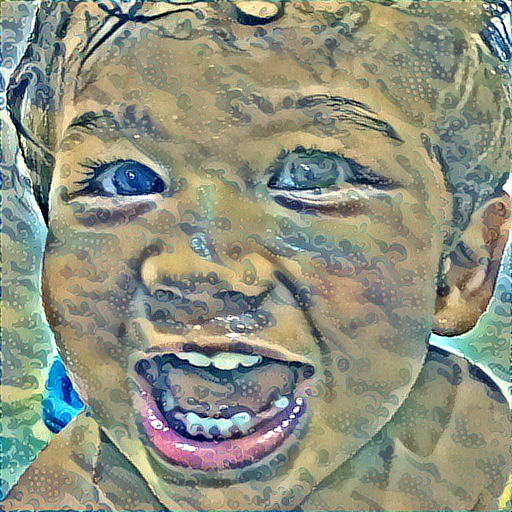

In [32]:
Image.fromarray(x)

In [ ]:
#1.為什麼ＲＧＢ減三個數直 做反轉 最後在＋回  反轉回原本
#2.function x   ...return 
#LBGFS